# Projet de Classification des Pathologies Dentaires 🦷

## Aperçu du Projet 📋

Dans ce projet, nous visons à classer diverses pathologies dentaires à l'aide de techniques de deep learning. Le jeu de données comprend des images de conditions dentaires telles que :

* Caries
* Tartre
* Gingivite
* Ulcères
* Décoloration dentaire
* Hypodontie

Nous entraînerons un Réseau de Neurones Convolutif (CNN) basé sur l'architecture ResNet18 pour classer automatiquement ces pathologies.

Commençons !

### Les bibliotheques 📚

In [2]:
# Import the necessary library
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet18

In [3]:
import zipfile
with zipfile.ZipFile('/content/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset_source1')

##  Organisation des images de pathologies dentaires 🖼️

In [4]:
# Define the original directories and their corresponding class names
original_dirs = {
    'Calculus': '/content/dataset_source1/Calculus/Calculus',
    'Caries': '/content/dataset_source1/Data caries/Data caries/caries augmented data set/preview',
    'Gingivitis': '/content/dataset_source1/Gingivitis/Gingivitis',
    'Ulcers': '/content/dataset_source1/Mouth Ulcer/Mouth Ulcer/Mouth_Ulcer_augmented_DataSet/preview',
    'Tooth Discoloration': '/content/dataset_source1/Tooth Discoloration/Tooth Discoloration /Tooth_discoloration_augmented_dataser/preview',
    'Hypodontia': '/content/dataset_source1/hypodontia/hypodontia'
}

# Define the target base directory
base_dir = '/content/dataset_organise'

# Define the target structure
splits = ['train', 'val', 'test']
classes = list(original_dirs.keys())

# Create target directories
for split in splits:
    for class_name in classes:
        os.makedirs(os.path.join(base_dir, split, class_name), exist_ok=True)

# Initialize dictionaries to hold the counts for train, val, and test sets
class_split_counts = {class_name: {'train': 0, 'val': 0, 'test': 0} for class_name in classes}

In [5]:
# Function to copy images to the target directory and count them
def copy_and_count_images(class_name, image_paths):
    # Split the data
    train_paths, test_paths = train_test_split(image_paths, test_size=0.1, random_state=42)
    train_paths, val_paths = train_test_split(train_paths, test_size=0.2, random_state=42)  # 0.2 * 0.9 = 0.18

    # Define split mappings
    split_paths = {
        'train': train_paths,
        'val': val_paths,
        'test': test_paths
    }

    # Copy images to their respective directories and count them
    for split, paths in split_paths.items():
        class_split_counts[class_name][split] = len(paths)
        for img_path in paths:
            target_path = os.path.join(base_dir, split, class_name, os.path.basename(img_path))
            shutil.copy(img_path, target_path)

In [6]:
# Traverse the original directories and gather image paths
for class_name, original_dir in original_dirs.items():
    image_paths = []
    for root, dirs, files in os.walk(original_dir):
        image_paths.extend([os.path.join(root, file) for file in files if file.lower().endswith(('.jpg', '.jpeg', '.png'))])
    if image_paths:
        print(f'Found {len(image_paths)} images for {class_name}')
        copy_and_count_images(class_name, image_paths)

print('\nImages have been copied and organized successfully.')

Found 1296 images for Calculus
Found 2382 images for Caries
Found 2349 images for Gingivitis
Found 2541 images for Ulcers
Found 1834 images for Tooth Discoloration
Found 1251 images for Hypodontia

Images have been copied and organized successfully.


In [7]:
# Print the distribution of images in each split
print('\nDistribution of images in each split:')
for class_name in classes:
    print(f'\n{class_name}:')
    for split in splits:
        count = class_split_counts[class_name][split]
        print(f'  {split}: {count} images')

# Print total counts
print('\nTotal counts:')
total_counts = {split: sum(class_split_counts[class_name][split] for class_name in classes) for split in splits}
for split, count in total_counts.items():
    print(f'  {split}: {count} images')
print(f'  Total: {sum(total_counts.values())} images')


Distribution of images in each split:

Calculus:
  train: 932 images
  val: 234 images
  test: 130 images

Caries:
  train: 1714 images
  val: 429 images
  test: 239 images

Gingivitis:
  train: 1691 images
  val: 423 images
  test: 235 images

Ulcers:
  train: 1828 images
  val: 458 images
  test: 255 images

Tooth Discoloration:
  train: 1320 images
  val: 330 images
  test: 184 images

Hypodontia:
  train: 900 images
  val: 225 images
  test: 126 images

Total counts:
  train: 8385 images
  val: 2099 images
  test: 1169 images
  Total: 11653 images


 ## Affichage d'images aléatoires 🖼️

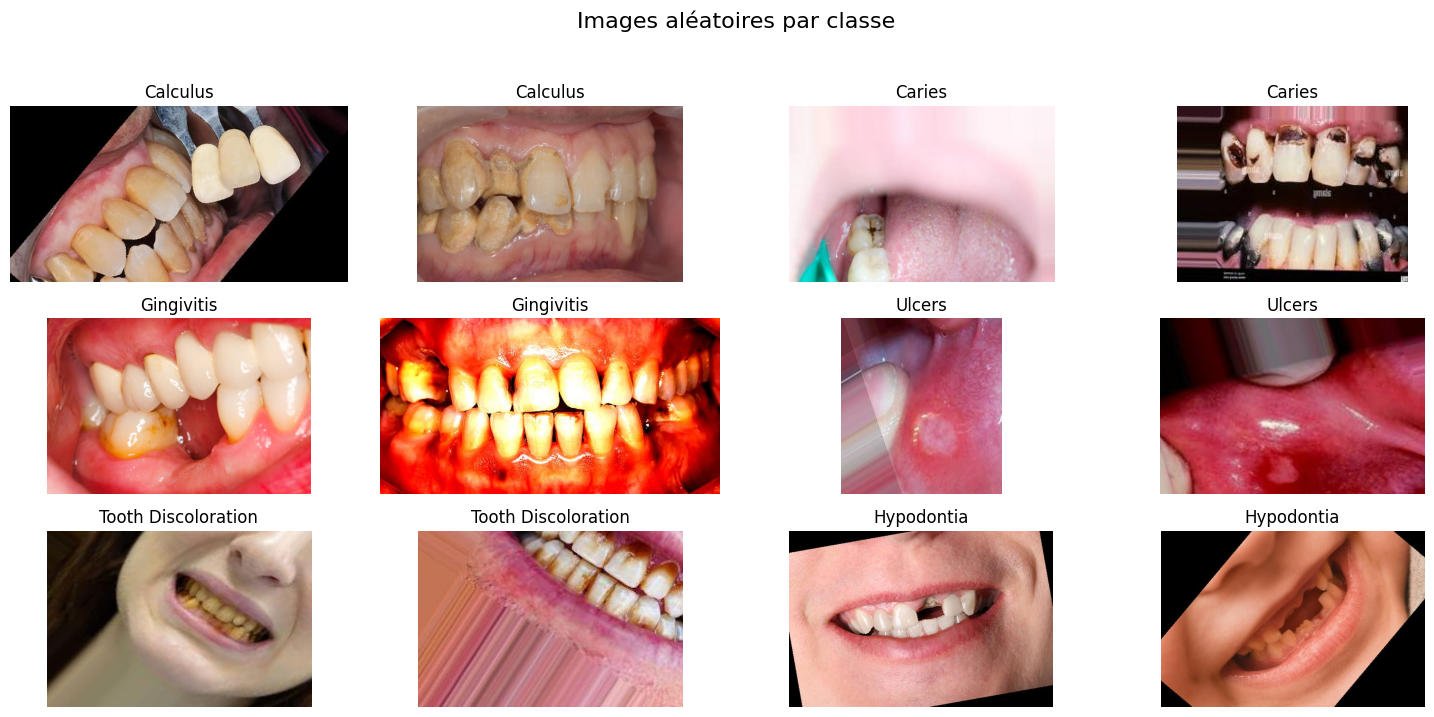

In [8]:
# Configuration des paramètres d'affichage
num_images_per_class = 2    # Nombre d'images à afficher par classe
num_images_per_row = 4      # Nombre d'images par ligne
random.seed(42)             # Initialisation de la graine aléatoire

def get_random_images_from_dir(directory, num_images):
    """
    Récupère des images aléatoires d'un répertoire donné
    Args:
        directory (str): Chemin du répertoire
        num_images (int): Nombre d'images à récupérer
    Returns:
        list: Liste des chemins d'images sélectionnées
    """
    all_images = [os.path.join(directory, img) for img in os.listdir(directory)
                 if img.endswith(('.jpg', '.jpeg', '.png'))]

    if len(all_images) < num_images:
        return all_images
    return random.sample(all_images, num_images)

# Calcul du nombre de lignes nécessaires
num_rows = (len(classes) * num_images_per_class + num_images_per_row - 1) // num_images_per_row

# Création de la figure et des sous-graphiques
fig, axs = plt.subplots(num_rows, num_images_per_row, figsize=(15, num_rows * 2.5))
fig.suptitle('Images aléatoires par classe', fontsize=16)
axs = axs.flatten()

# Parcours et affichage des images
image_idx = 0
for class_name in classes:
    class_dir = os.path.join(base_dir, 'train', class_name)
    random_images = get_random_images_from_dir(class_dir, num_images_per_class)

    for img_path in random_images:
        if image_idx < len(axs):
            img = Image.open(img_path)
            ax = axs[image_idx]
            ax.imshow(img)
            ax.set_title(class_name)
            ax.axis('off')
            image_idx += 1
# Ajustement de la mise en page
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Data Visualization  📊

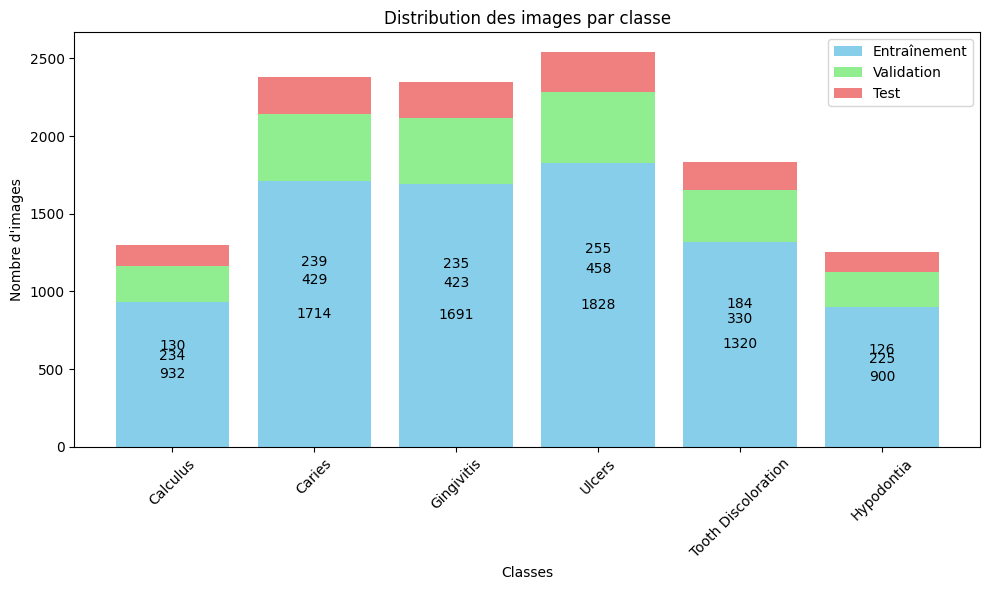

In [9]:
# Initialisation des dictionnaires pour les ensembles train, val et test
class_split_counts = {class_name: {'train': 0, 'val': 0, 'test': 0} for class_name in classes}

def count_images(base_dir, class_name):
    counts = {}
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(base_dir, split, class_name)
        counts[split] = len(os.listdir(split_dir))
    return counts

# Calcul des comptages pour chaque classe
for class_name in classes:
    class_split_counts[class_name] = count_images(base_dir, class_name)

# Préparation des données pour le graphique
labels = classes
train_counts = [class_split_counts[class_name]['train'] for class_name in classes]
val_counts = [class_split_counts[class_name]['val'] for class_name in classes]
test_counts = [class_split_counts[class_name]['test'] for class_name in classes]

x = range(len(classes))

# Création du graphique à barres empilées
fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(x, train_counts, label='Entraînement', color='skyblue')
bar2 = ax.bar(x, val_counts, bottom=train_counts, label='Validation', color='lightgreen')
bar3 = ax.bar(x, test_counts, bottom=[i+j for i,j in zip(train_counts, val_counts)],
              label='Test', color='lightcoral')

ax.set_xlabel('Classes')
ax.set_ylabel("Nombre d'images")
ax.set_title('Distribution des images par classe')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

# Ajout des étiquettes de données
for bar in bar1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval/2, int(yval),
            ha='center', va='center', color='black')

for bar in bar2:
    yval = bar.get_height() + bar.get_y()
    ax.text(bar.get_x() + bar.get_width()/2, yval/2, int(bar.get_height()),
            ha='center', va='center', color='black')

for bar in bar3:
    yval = bar.get_height() + bar.get_y()
    ax.text(bar.get_x() + bar.get_width()/2, yval/2, int(bar.get_height()),
            ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

## Model Preparing and Training 🧠

In [61]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

image_size = (224,224)
batch_size = 32
num_epochs = 30

from torchvision import transforms

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

train_dataset = ImageFolder(train_dir,transform=train_transform)
val_dataset = ImageFolder(val_dir,transform=val_transform)
test_dataset = ImageFolder(test_dir,transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import densenet121

# Get number of classes
num_classes = len(train_dataset.classes)

# Use a smaller model - DenseNet121
class CustomDenseNet(nn.Module):
    def __init__(self):
        super(CustomDenseNet, self).__init__()
        self.model = densenet121(weights=True)  # Load pre-trained DenseNet121
        self.model.classifier = nn.Linear(self.model.classifier.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize the model, loss function, and optimizer
model = CustomDenseNet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=1e-4)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [63]:
# Set environment variable to avoid threading issues
os.environ["OMP_NUM_THREADS"] = "1"

# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Early stopping parameters
early_stopping = True
patience = 3  # Number of epochs to wait if no improvement is observed

# Initialize early stopping variables
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

# Initialize lists to store losses, accuracies, and learning rates
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Variables to store y_true and y_scores for precision-recall calculation
y_true = []
y_scores = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_true = []
    val_outputs = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_true.extend(labels.cpu().numpy())
            val_outputs.extend(outputs.cpu().numpy())

    val_loss = val_loss / len(val_dataset)
    val_acc = accuracy_score(val_true, val_preds)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Append true labels and predicted scores for precision-recall calculation
    y_true.extend(val_true)
    y_scores.extend(val_outputs)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Check for improvement in validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the model checkpoint here if you want

    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f'Early stopping after {epoch+1} epochs.')
            early_stop = True
            break

    # LR scheduler step based on validation loss
    scheduler.step(val_loss)

    if early_stop:
        break

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/30], Train Loss: 0.5318, Val Loss: 0.3469, Val Acc: 0.8628


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [2/30], Train Loss: 0.2174, Val Loss: 0.2713, Val Acc: 0.8733


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [3/30], Train Loss: 0.1785, Val Loss: 0.2419, Val Acc: 0.8890


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [4/30], Train Loss: 0.1497, Val Loss: 0.2568, Val Acc: 0.8895


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [5/30], Train Loss: 0.1409, Val Loss: 0.2489, Val Acc: 0.8947


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [6/30], Train Loss: 0.1376, Val Loss: 0.2597, Val Acc: 0.8880
Early stopping after 6 epochs.


## Model Evaluation 📉

In [64]:
# Test the model
model.eval()
test_preds = []
test_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_true.extend(labels.cpu().numpy())

test_acc = accuracy_score(test_true, test_preds)
print(f'Test Accuracy: {test_acc:.4f}')

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Accuracy: 0.9093


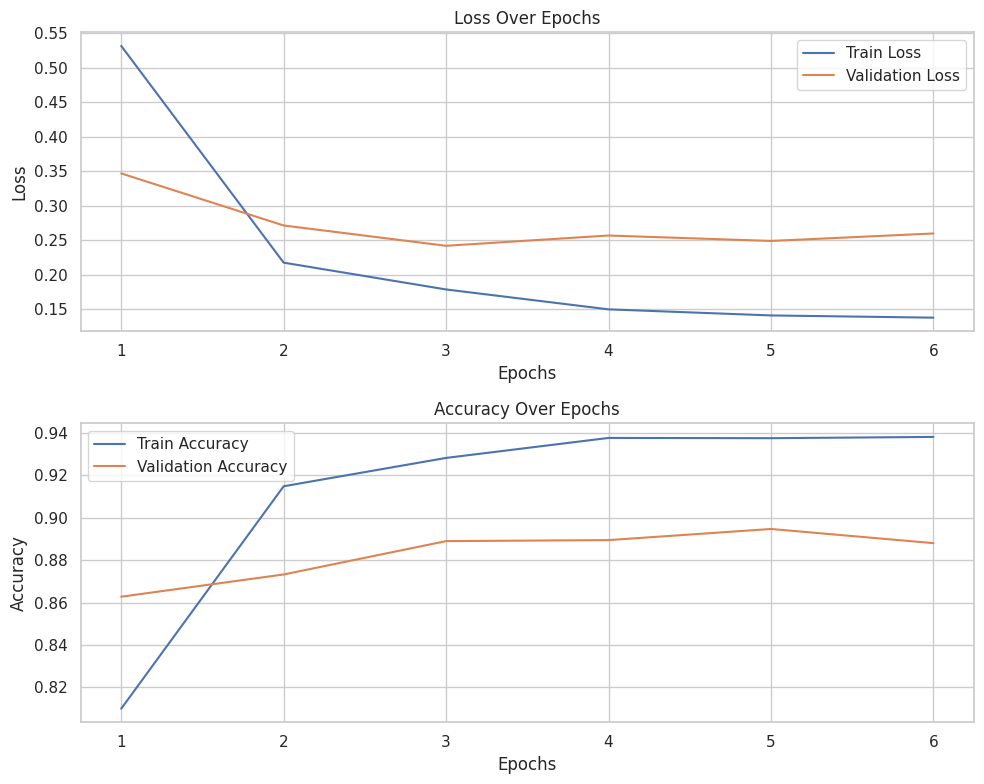

In [65]:
import seaborn as sns

sns.set(style="whitegrid")

epochs_range = range(1, len(train_losses) + 1)

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Loss plot
sns.lineplot(x=epochs_range, y=train_losses, label='Train Loss', ax=axs[0])
sns.lineplot(x=epochs_range, y=val_losses, label='Validation Loss', ax=axs[0])
axs[0].set_title('Loss Over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Accuracy plot
sns.lineplot(x=epochs_range, y=train_accuracies, label='Train Accuracy', ax=axs[1])
sns.lineplot(x=epochs_range, y=val_accuracies, label='Validation Accuracy', ax=axs[1])
axs[1].set_title('Accuracy Over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()


In [66]:
 # Generate classification report
class_names = test_dataset.classes
report = classification_report(test_true, test_preds, target_names=class_names)

# Display classification report
print("Classification Report:")
print(report)

Classification Report:
                     precision    recall  f1-score   support

           Calculus       0.79      0.61      0.69       130
             Caries       0.96      0.96      0.96       239
         Gingivitis       0.82      0.88      0.85       235
         Hypodontia       0.97      0.96      0.96       126
Tooth Discoloration       0.91      0.95      0.93       184
             Ulcers       0.96      0.98      0.97       255

           accuracy                           0.91      1169
          macro avg       0.90      0.89      0.89      1169
       weighted avg       0.91      0.91      0.91      1169



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


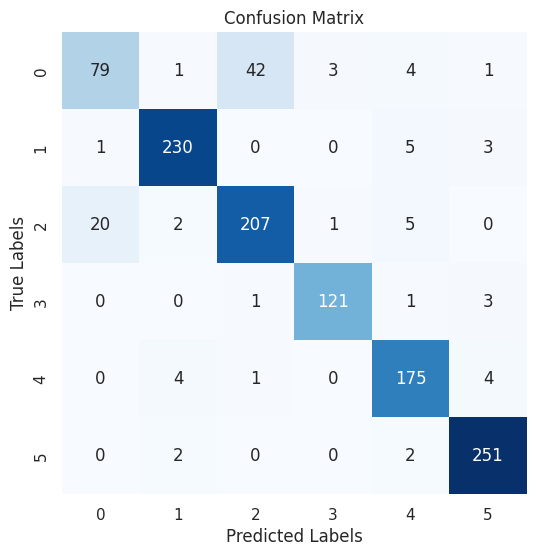

In [67]:
# Get predictions for the test set
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# # Save the model
# model_save_path = "dental_disease_model.pth"
# torch.save(model.state_dict(), model_save_path)
# print(f"Model saved to {model_save_path}")

In [ ]:
# # Create the same model structure first
# model = CustomDenseNet()
# model.load_state_dict(torch.load("dental_disease_model.pth"))
# model = model.to(device)
# model.eval()  # Important : mettre le modèle en mode évaluation